<a href="https://colab.research.google.com/github/federicodecillia/easyprophet/blob/main/easyprophet_examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example usages of easyprophet package

In [20]:
############--- Install & import python packages ---############
import numpy as np
import pandas as pd
import os
from datetime import datetime, date
import time
import traceback
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore", category=UserWarning)

############--- fbprophet packages ---############
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.plot import add_changepoints_to_plot
import altair as alt
from fbprophet.plot import plot_plotly
import plotly.offline as py
!pip install pydataset # pydataset used to load sample data
from pydataset import data

############--- easyprophet package ---############
!pip install easyprophet
from easyprophet import easyprophet

# 1 Set-up parameters to read/write files

In [76]:
############--- Parameters for input/output files ---#########
input_sheet = "" # Name of the input file
date_var = "date"                       # Name of the Date variable in the input file (e.g. date)
y_var = "unemploy"                      # Name of the colum containing the y variable in the input file
x_vars = ["pce", "pop", "psavert",]     # List containing names of the exogenous variables. False for no exogenous variable
sample_data = True                      # Whether to use sample_data or custom data stored by the user in GDrive
output_path = "drive/My Drive/Colab Notebooks/Output/" # GDrive path where output will be stored

############--- Parameters for prophet modeling ---#########
future_pred_period = 28       # N° of periods (hours/days/months) to predict in the future. False for no future predictions (default=False)
freq_data = "M"               # Frequency of the data, and of the period to be predicted (pd.date_range format: 'H':hourly, 'D':Daily, 'M':Monthly)
freq_period = 12              # Frequency of the period (24 for "H", 7 for "D", 12 for "M")
list_holidays = []            # list of custom holidays. E.g. ["2020-01-01","2020-01-31"]. [] for nothing (default=[])
x_standardize = "auto"        # used only when x_vars not False: Whether to standardize the regressors prior to fitting. Can be 'auto' (standardize if not binary), True, or False. (default="auto")
growth="linear"               # linear or logistic trend. If logistic you need to provide cap and floor of your predictions as well as historic data (default="linear")
cap=False,                    # Name of the column containing the carrying capacity, i.e. the saturating maximum (must be specified for every row in the df).
floor=False,                  # Name of the column containing the floor (saturating minimum). To use a logistic growth trend with a saturating minimum, a maximum capacity must also be specified.
yearly_seasonality = True     # Whether to include yearly seasonality. Can be 'auto', True, False (default="auto")
weekly_seasonality = False    # Whether to include weekly seasonality. Can be 'auto', True, False (default="auto")
daily_seasonality = False     # Whether to include daily seasonality. Can be 'auto', True, False (default="auto")
custom_seasonality = False    # List, containing custom seasonality's [name, freq_period in a year, fourier_order] (e.g ["Quarterly", (365.25/4), 10]
seasonality_mode ="additive"  # 'additive' or 'multiplicative' (default="additive")
seasonality_prior_scale=10.0  # strength of the seasonality model. larger values => larger seasonal fluctuations (default=10.0)
holidays_prior_scale=10.0     # strength of the holiday components model (default=10.0)
holidays_country="US"         # name of the country of which load standard holidays (e.g. "US"), False for nothing (default=False)
interval_width=0.90           # Float, width of the uncertainty intervals provided for the forecast (default=0.80)
changepoints=None             # List of dates at which to include potential changepoints (default=None)
n_changepoints=25             # Number of potential changepoints to include. Not used if input `changepoints` is supplied (default=25)
changepoint_range=0.90        # Proportion of history in which trend changepoints will be estimated (default=0.80)
changepoint_prior_scale=0.05  # Flexibility of automatic changepoint selection & consequently of the trend. Increase it to make the trend more flexible (default=0.05) 

############--- Parameters for prophet cross-validation ---#########
cv_initial ='7300 days'       # the size of the initial training period
cv_period  ='365 days'        # the spacing between cutoff dates
cv_horizon ='730 days'        # the forecast horizon
cv_rolling_window = 0.2      # proportion of forecasts to use in each rolling window (default=0.1, corresponding to 10% of rows from df_cv included in each window). Increasing it will lead to a smoother curve in the plot

############--- Create df_holidays containing custom holidays specified in the list_holidays param ---#########
df_holidays = pd.DataFrame({'holiday': 'holiday', 
                            'ds': pd.to_datetime(list_holidays),
                            'lower_window': 0,
                            'upper_window': 0})

# 1. Load Data
### 1.A Load sample data from pydataset
### 1.B Load custom data, from personal Google Drive
To connect your Google Account:
1. Execute the script
2. Visit the link provided and login with your Google account
3. Copy the code that is provided and paste it below in the cell where required
4. If everything worked correctly you'll receive a message like: Mounted at /content/gdrive
5. Once mounted Google Drive, go to the left panel, click on "*files*" and locate your data in your Google Drive folder. 

**Recommendation**: To Read the data automatically locate it in: *gdrive/My Drive/Colab Notebooks/Data/*

In [68]:
if sample_data:
  df = data("economics")
else:
    google.colab.drive.mount('/content/gdrive')

    ### Choose one of the 3 options below to read data from csv, xlsx or Google Sheet

    ### A. Read csv file
    df = pd.read_csv(f"gdrive/My Drive/Colab Notebooks/Data/{input_f}", sep=f_sep, decimal=f_dec)

    ### B. Read xlsx file
    df = pd.read_excel(f"gdrive/My Drive/Colab Notebooks/Data/{input_f}", sheets=sheet_f, header=0)

    ### C. Read data from Google Sheet
    auth.authenticate_user()
    gc = gspread.authorize(GoogleCredentials.get_application_default())
    worksheet = gc.open(input_sheet).sheet1
    df = pd.DataFrame.from_records(worksheet.get_all_values())
    new_header = df.iloc[0] 
    df = df[1:] 
    df.columns = new_header 
    df = df.apply(pd.to_numeric, errors='ignore')

print(f"Shape of input df: {df.shape}")
df.head()

Shape of input df: (478, 6)


,date,pce,pop,psavert,uempmed,unemploy
1,1967-06-30,507.8,198712,9.8,4.5,2944
2,1967-07-31,510.9,198911,9.8,4.7,2945
3,1967-08-31,516.7,199113,9.0,4.6,2958
4,1967-09-30,513.3,199311,9.8,4.9,3143
5,1967-10-31,518.5,199498,9.7,4.7,3066


### 1.2 Create the time series dataframe containing just *date_var* (datetime format) & *y_var*

In [69]:
ts = easyprophet.create_ts(df=df, date_var=date_var, y_var=y_var, sort_ts=True)

print(f"\nShape of ts: {ts.shape};   Shape of ts after removing missing: {ts.dropna().shape};   Frequency of data: '{freq_data}'")
ts = ts.dropna()
ts.head()


Shape of ts: (478, 2);   Shape of ts after removing missing: (478, 2);   Frequency of data: 'M'


,ds,y
1,1967-06-30,2944
2,1967-07-31,2945
3,1967-08-31,2958
4,1967-09-30,3143
5,1967-10-31,3066


# A. UNIVARIATE PROPHET MODELING `y(t) = g(t) + s(t) + h(t) + et`

### A.1 Fit the Prophet model (for past & future observations):
* Display the plot of **observed values** (black dots), **predicted values** (blue lines), **lower & upper limit of the interval of confidence** (light-blue area), **changepoint lines** (i.e. period in time when the trend changes, identified by vertical red lines)
* Display the **Forecast components**: Trend, Seasonalities (daily / weekly / yearly), holidays (if *holidays_country* parameter have been set)

1.A Plot of Observed & Predicted values + Changepoints (date points where the time series have abrupt changes in the trajectory)
1.B Plot of Observed & Predicted values - in interactive window


2. Plot of forecasts components: Trend & seasonality (weekly/yearly & holidays if added)


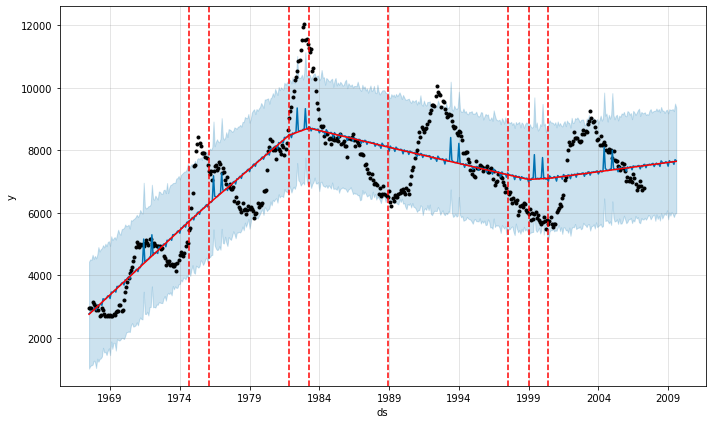

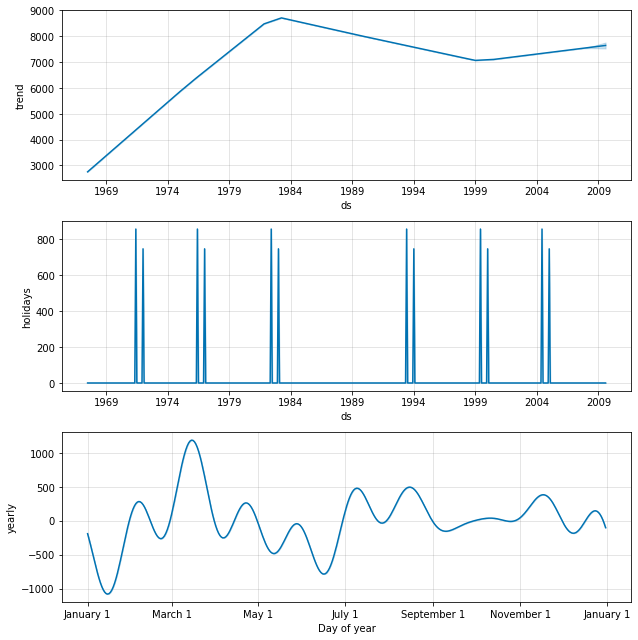

In [70]:
df_pred, m, seasonalities = easyprophet.fit_predict(
    df=ts,                         # input df. Must contain 2 colums: "ds" and "y", and optionally all the exogenous variables(x_vars) 
    df_holidays=df_holidays,       # df with columns holiday (string) and ds (date type) (default=[] i.e. No customing holidays)
    plot_predictions=True,         # Boolean, whether to plot the Predictions & Observed values or not
    plot_pred_interactive=True,    # Boolean, whether to plot Predictions & Observed values using an Interactive plots of plotly
    plot_components=True,          # Boolean, whether to plot forecasts components: Trend & seasonalities (weekly/yearly & holidays if added)
    freq_data=freq_data,                             # Frequency of the data, used for making future predictions (pd.date_range format: 'H':hourly, 'D':Daily, 'MS':Month Start, 'M':Month End)
    future_pred_period=future_pred_period,           # N° of periods (hours/days/weeks) to predict in the future. False for no future predictions (default=False)
    growth=growth,                                   # linear or logistic trend. If logistic you need to provide cap and floor of your predictions as well as historic data.  (default="linear")
    cap=cap,                                         # Name of the column containing the carrying capacity, i.e. the saturating maximum (must be specified for every row in the df).
    floor=floor,                                     # Name of the column containing the floor (saturating minimum). To use a logistic growth trend with a saturating minimum, a maximum capacity must also be specified.
    yearly_seasonality=yearly_seasonality,           # Whether to include yearly seasonality. Can be 'auto', True, False (default="auto")
    weekly_seasonality=weekly_seasonality,           # Whether to include weekly seasonality. Can be 'auto', True, False (default="auto")
    daily_seasonality=daily_seasonality,             # Whether to include daily seasonality.  Can be 'auto', True, False (default="auto")
    custom_seasonality=custom_seasonality,           # List, containing custom seasonality's [name, freq_period in a year, fourier_order] (e.g ["Quarterly", (365.25/4), 10]
    seasonality_mode=seasonality_mode,               # 'additive' or 'multiplicative' (default="additive")
    seasonality_prior_scale=seasonality_prior_scale, # strength of the seasonality model. larger values => larger seasonal fluctuations (default=10.0)
    holidays_prior_scale=holidays_prior_scale,       # strength of the holiday components model (default=10.0)
    holidays_country=holidays_country,               # name of the country of which load standard holidays (e.g. "US") (default=False)
    interval_width=interval_width,                   # Float, width of the uncertainty intervals provided for the forecast (default=0.80)
    changepoints=changepoints,                       # List of dates at which to include potential changepoints (default=None)
    n_changepoints=n_changepoints,                   # Number of potential changepoints to include. Not used if input `changepoints` is supplied (default=25)
    changepoint_range=changepoint_range,             # Proportion of history in which trend changepoints will be estimated (default=0.80)
    changepoint_prior_scale=changepoint_prior_scale, # Flexibility of automatic changepoint selection & consequently of the trend. Increase it to make the trend more flexible (default=0.05) 
   )

### A.2 Detect Anomalies in the data, and export the full table of predictions
The table below contains the output of the model. It contains the following columns:
* **ds**: date/time of the observation
* **trend**: underlying trend in case of no seasonal/holidays effect. It’s the g(t) in the formula above
* **yhat_lower / upper**: lower/upper limit of the interval of confidence of the predictions
* **yearly / weekly / daily**: seasonal effects on the prediction for each ds. It’s the s(t) in the formula above
* **holidays**: seasonal effect of the holidays on the prediction for each ds.
It’s the h(t) in the formula above
* **yhat**: Predicted value considering all the effects. 
It’s the y(t) in the formula above
* **fact**: Real observed value, useful to compare it with yhat and check the performance of the predictions
* **anomaly**: Categoric variables used to signal if observed values are higher/lower than the interval of confidence created
  * anomaly = 1 if fact > yhat_upper
  * anomaly = -1 if fact < yhat_lower
  * anomaly = 0 if yhat_lower < fact < yhat_upper
* **importance**: importance of the anomaly in % terms. 
  * if anomaly = 1: importance = fact - yhat upper
  * if anomaly = -1: importance = yhat lower - fact

A **sample** of the table is reported below, while the whole table (including all observations) is being **exported** in a file with the name specified by the  *f_out_name* parameter below

In [73]:
#### IMPORTANT: Be sure to have the output path in your Gdrive: "drive/My Drive/DSci_Conference_Nov20_iMediaTamKPIs_FD&RT/Output/"
df_anomalies = easyprophet.detect_anomalies(df_pred)

if not sample_data:
  f_out_name = f"{y_var}_predictions.csv"    # Choose the desired output file name
  df_anomalies.to_csv(f"{output_path}{f_out_name}")
  print(f"Exported df containing anomalies & predictions")

print(f"N° of anomalies: {len(df_anomalies[df_anomalies['anomaly']!=0])} on {len(df_anomalies)} rows"
      f" ({len(df_anomalies[df_anomalies['anomaly']!=0]) / len(df_anomalies):0.1%} of total)")
df_anomalies[df_anomalies['anomaly']!=0].head()

N° of anomalies: 38 on 506 rows (7.5% of total)


,ds,trend,yhat_lower,yhat_upper,holidays,yearly,yhat,fact,anomaly,importance
92,1975-02-28,5923.328667,4306.481652,7530.707560,0.0,-31.518027,5891.810640,7978.0,1,0.056066
93,1975-03-31,5957.335926,4279.518595,7719.222342,0.0,35.443949,5992.779875,8210.0,1,0.059778
94,1975-04-30,5990.246176,4244.825037,7750.024485,0.0,37.626492,6027.872668,8433.0,1,0.080988
95,1975-05-31,6024.253435,4290.822185,7712.227103,0.0,-73.582227,5950.671208,8220.0,1,0.061773
96,1975-06-30,6057.163685,4482.132896,7776.613783,0.0,17.974103,6075.137788,8127.0,1,0.043114


### A.3 Diagnostics: cross validation for a range of historical cutoffs to measure forecast error
Perform cross-validation selecting cutoff points in the past and by fitting the model for each of them using data only up to that cutoff point.

This technique has many advantages on the simple split of train & test set, in fact it uses many train & test sets (at different periods), and  compute the average performance on them, providing more reliable forecast errors and increasing the generalizability of the model.

#### A.3.1 Use the cross_validation functions. Specify the following parameters:
* **initial**: the size of the initial training period
* **period**: the spacing between cutoff dates
* **horizon**: the forecast horizon
* **Output**: A df containing observed (y) and predicted (yhat) values, at each simulated forecast date and each cutoff date. A forecast is made for every observed point between cutoff and cutoff + horizon. 

Periods must be specified using pd.Timedelta compatible style (e.g. '5 days', '3 hours', '10 seconds').

For reference: https://facebook.github.io/prophet/docs/diagnostics.html

In [77]:
df_cv = cross_validation(m,
                         initial = cv_initial, 
                         period  = cv_period,  
                         horizon = cv_horizon,
                         )
df_cv.head()

INFO:fbprophet:Making 18 forecasts with cutoffs between 1988-04-04 00:00:00 and 2005-03-31 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1988-04-30,7563.000475,5969.185714,9078.128325,6779,1988-04-04
1,1988-05-31,7440.789365,5986.749501,8958.317494,6546,1988-04-04
2,1988-06-30,7592.016161,6189.812914,9197.603412,6605,1988-04-04
3,1988-07-31,7480.630554,5959.260559,9052.245840,6843,1988-04-04
4,1988-08-31,7404.934780,5799.159092,8946.379367,6604,1988-04-04


#### A.3.2. Compute accuracy of the prediction

* **MSE**: Mean Squared Error
* **RMSE**: Root Mean Squared Error
* **MAE** Mean Absolute Error
* **MAPE**: Mean Absolute Percentage Error

These are computed on a rolling window of the predictions in df_cv (rolling_window parameter) after sorting by horizon (ds minus cutoff). 

The 1° table below shows a sample of the accuracy of predictions varying the horizon period.

The 2° table below shows more generally the basic descriptive statistics of the performances. It's particularly important to pay attention to the mean of MAPE because it assess the Mean Average Percentage Error that we can expect applying this model to future data.

In [78]:
df_p = performance_metrics(df_cv)

if not sample_data:
    f_out_name = f"{y_var}_performance.csv"    # Choose the desired output file name
    df_p.to_csv(f"{output_path}{f_out_name}", index=False)
    print(f"Exported df containing performance of Prophet model")

print("Descriptive statistics for each performance metric:")
df_p.drop(axis=1, columns={"horizon"}).describe()

Descriptive statistics for each performance metric:


,mse,rmse,mae,mape,mdape,coverage
count,1.090000e+02,109.000000,109.000000,109.000000,109.000000,109.000000
mean,3.014229e+06,1715.425992,1466.653254,0.189002,0.184581,0.644869
std,9.122164e+05,268.709700,261.844720,0.033865,0.040333,0.085011
min,1.610143e+06,1268.914275,1020.840479,0.131074,0.108262,0.488372
25%,2.199881e+06,1483.199518,1254.430106,0.161602,0.165177,0.581395
50%,3.060694e+06,1749.484052,1484.878725,0.190536,0.181671,0.651163
75%,3.661876e+06,1913.602995,1703.474114,0.221362,0.213056,0.697674
max,4.665155e+06,2159.897020,1890.518115,0.244352,0.265011,0.796512


#### A.3.3 Visualize Cross validation performance metrics
* **Dots** show the error for each prediction in df_cv. 
* **The blue line** shows the metric selected (mse, rmse, mae, mape), where the mean is taken over a rolling window of the dots
* The **rolling_window** parameter specifies the proportion of forecasts to use in each rolling window (default=0.1, corresponding to 10% of rows from df_cv included in each window). Increasing this will lead to a smoother average curve in the figure.

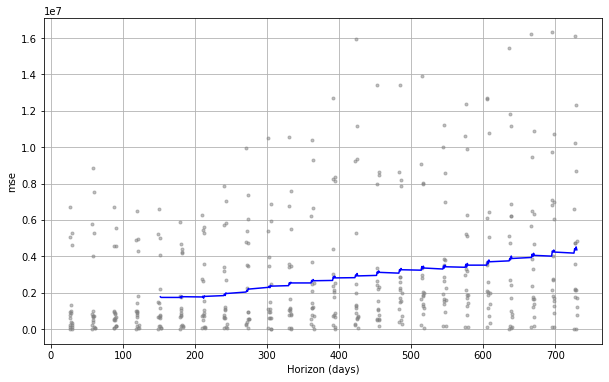

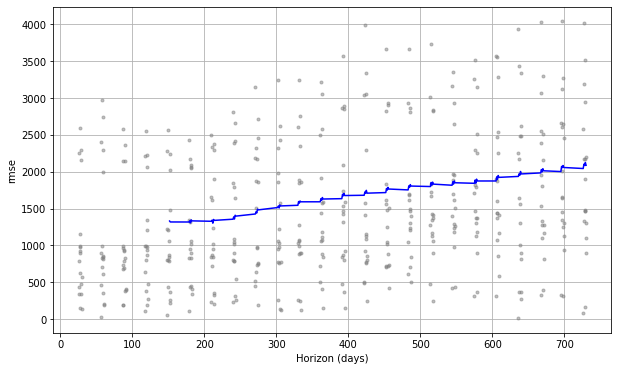

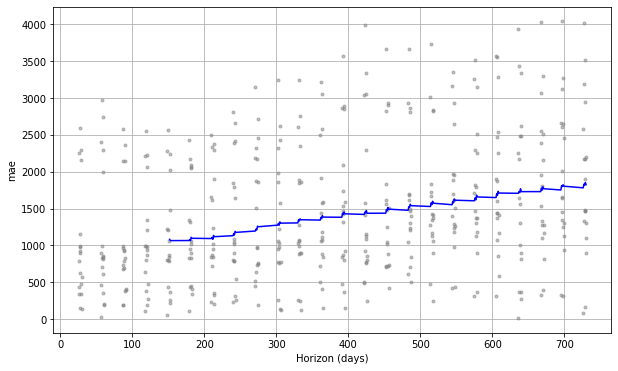

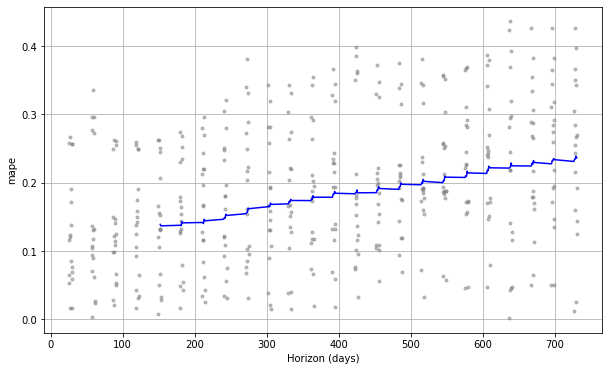

In [80]:
list_metrics = ["mse", "rmse", "mae", "mape"]
for metrics_i in list_metrics:
    fig = plot_cross_validation_metric(df_cv,
                                       metric=metrics_i,
                                       rolling_window=cv_rolling_window)

### A.4 Models comparison & parameters fine-tuning
In this section we compare 2 or more different models having different parameters (editable manually in the fit_predict function).
Once the models are fitted, it’s possible to compare the results obtained in order to identify which parameters return the best performance.
This is done first graphically (A.4.1), and then performing a grid-search (A.4.2).

#### A.4.1. Fit & compare 2 or more models having some different parameters

1.A Plot of Observed & Predicted values + Changepoints (date points where the time series have abrupt changes in the trajectory)


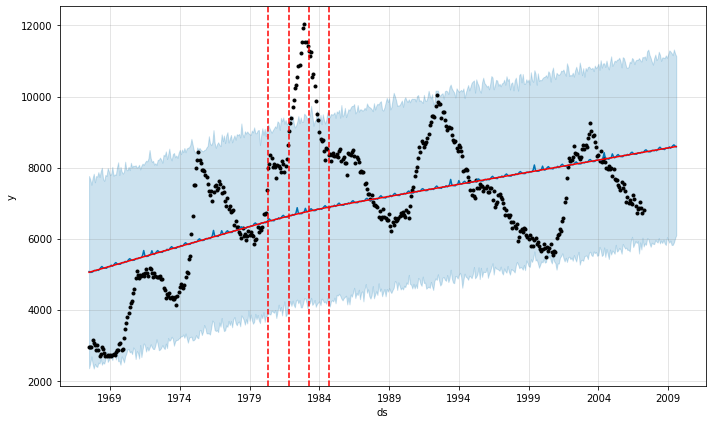

In [81]:
df_pred1, m1, seasonalities = easyprophet.fit_predict(
    df=ts,                         # input df. Must contain 2 colums: "ds" and "y", and optionally all the exogenous variables(x_vars) 
    df_holidays=df_holidays,       # df with columns holiday (string) and ds (date type) (default=[] i.e. No customing holidays)
    plot_predictions=True,         # Boolean, whether to plot the Predictions & Observed values or not
    plot_pred_interactive=False,   # Boolean, whether to plot Predictions & Observed values using an Interactive plots of plotly
    plot_components=False,         # Boolean, whether to plot forecasts components: Trend & seasonalities (weekly/yearly & holidays if added)
    freq_data=freq_data,                             # Frequency of the data, used for making future predictions (pd.date_range format: 'H':hourly, 'D':Daily, 'MS':Month Start, 'M':Month End)
    future_pred_period=future_pred_period,           # N° of periods (hours/days/weeks) to predict in the future. False for no future predictions (default=False)
    growth=growth,                                   # linear or logistic trend. If logistic you need to provide cap and floor of your predictions as well as historic data.  (default="linear")
    cap=cap,                                         # Name of the column containing the carrying capacity, i.e. the saturating maximum (must be specified for every row in the df).
    floor=floor,                                     # Name of the column containing the floor (saturating minimum). To use a logistic growth trend with a saturating minimum, a maximum capacity must also be specified.
    yearly_seasonality=yearly_seasonality,           # Whether to include yearly seasonality. Can be 'auto', True, False (default="auto")
    weekly_seasonality=weekly_seasonality,           # Whether to include weekly seasonality. Can be 'auto', True, False (default="auto")
    daily_seasonality=daily_seasonality,             # Whether to include daily seasonality.  Can be 'auto', True, False (default="auto")
    custom_seasonality=custom_seasonality,           # List, containing custom seasonality's [name, freq_period in a year, fourier_order] (e.g ["Quarterly", (365.25/4), 10]
    seasonality_mode=seasonality_mode,               # 'additive' or 'multiplicative' (default="additive")
    seasonality_prior_scale=seasonality_prior_scale, # strength of the seasonality model. larger values => larger seasonal fluctuations (default=10.0)
    holidays_prior_scale=holidays_prior_scale,       # strength of the holiday components model (default=10.0)
    holidays_country=holidays_country,               # name of the country of which load standard holidays (e.g. "US") (default=False)
    interval_width=interval_width,                   # Float, width of the uncertainty intervals provided for the forecast (default=0.80)
    changepoints=changepoints,                       # List of dates at which to include potential changepoints (default=None)
    n_changepoints=n_changepoints,                   # Number of potential changepoints to include. Not used if input `changepoints` is supplied (default=25)
    changepoint_range=changepoint_range,             # Proportion of history in which trend changepoints will be estimated (default=0.80)
    changepoint_prior_scale=0.005,                    # Flexibility of automatic changepoint selection & consequently of the trend. Increase it to make the trend more flexible (default=0.05) 
    )

1.A Plot of Observed & Predicted values + Changepoints (date points where the time series have abrupt changes in the trajectory)


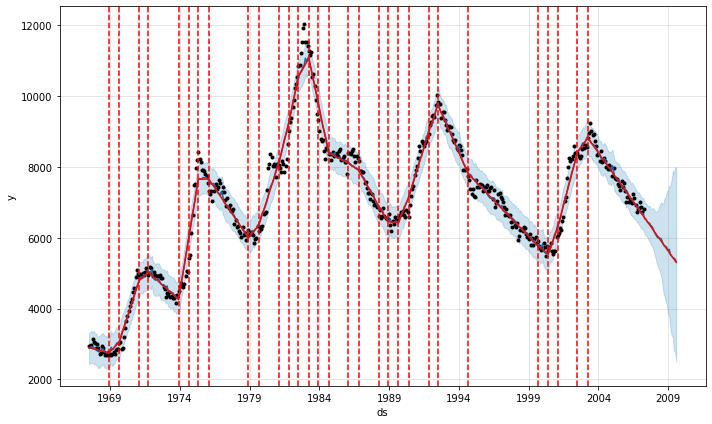

In [82]:
df_pred2, m2, seasonalities = easyprophet.fit_predict(
    df=ts,                         # input df. Must contain 2 colums: "ds" and "y", and optionally all the exogenous variables(x_vars) 
    df_holidays=df_holidays,       # df with columns holiday (string) and ds (date type) (default=[] i.e. No customing holidays)
    plot_predictions=True,         # Boolean, whether to plot the Predictions & Observed values or not
    plot_pred_interactive=False,   # Boolean, whether to plot Predictions & Observed values using an Interactive plots of plotly
    plot_components=False,         # Boolean, whether to plot forecasts components: Trend & seasonalities (weekly/yearly & holidays if added)
    freq_data=freq_data,                             # Frequency of the data, used for making future predictions (pd.date_range format: 'H':hourly, 'D':Daily, 'MS':Month Start, 'M':Month End)
    future_pred_period=future_pred_period,           # N° of periods (hours/days/weeks) to predict in the future. False for no future predictions (default=False)
    growth=growth,                                   # linear or logistic trend. If logistic you need to provide cap and floor of your predictions as well as historic data.  (default="linear")
    cap=cap,                                         # Name of the column containing the carrying capacity, i.e. the saturating maximum (must be specified for every row in the df).
    floor=floor,                                     # Name of the column containing the floor (saturating minimum). To use a logistic growth trend with a saturating minimum, a maximum capacity must also be specified.
    yearly_seasonality=yearly_seasonality,           # Whether to include yearly seasonality. Can be 'auto', True, False (default="auto")
    weekly_seasonality=weekly_seasonality,           # Whether to include weekly seasonality. Can be 'auto', True, False (default="auto")
    daily_seasonality=daily_seasonality,             # Whether to include daily seasonality.  Can be 'auto', True, False (default="auto")
    custom_seasonality=custom_seasonality,           # List, containing custom seasonality's [name, freq_period in a year, fourier_order] (e.g ["Quarterly", (365.25/4), 10]
    seasonality_mode=seasonality_mode,               # 'additive' or 'multiplicative' (default="additive")
    seasonality_prior_scale=seasonality_prior_scale, # strength of the seasonality model. larger values => larger seasonal fluctuations (default=10.0)
    holidays_prior_scale=holidays_prior_scale,       # strength of the holiday components model (default=10.0)
    holidays_country=holidays_country,               # name of the country of which load standard holidays (e.g. "US") (default=False)
    interval_width=interval_width,                   # Float, width of the uncertainty intervals provided for the forecast (default=0.80)
    changepoints=changepoints,                       # List of dates at which to include potential changepoints (default=None)
    n_changepoints=50,                               # Number of potential changepoints to include. Not used if input `changepoints` is supplied (default=25)
    changepoint_range=changepoint_range,             # Proportion of history in which trend changepoints will be estimated (default=0.80)
    changepoint_prior_scale=0.25,                    # Flexibility of automatic changepoint selection & consequently of the trend. Increase it to make the trend more flexible (default=0.05) 
   )

#### A.4.2. Create a grid of parameters to iteratively fit models & compare their diagnostic metrics
The grid-search creates Diagnostics results (same of section A.3) iteratively for each combination of models and parameters.
In this case are provided 3 different models (3 different settings).

The table below shows the performance of the 3 models fitted sorted in the way it was passed (1° row contains results of model m, 2° row of m1, 3° row of m2)

In [85]:
param_grid = {'model'   : [m, m1, m2],
              'initial' : [cv_initial],
              'period'  : [cv_period],
              'horizon' : [cv_horizon]}
param_grid = list(easyprophet.create_grid(param_grid))

cv_table = easyprophet.cross_validation_compare_models(cross_valid_params=param_grid, 
                                                       metric='mape')
cv_table

INFO:fbprophet:Making 18 forecasts with cutoffs between 1988-04-04 00:00:00 and 2005-03-31 00:00:00


INFO:fbprophet:Making 18 forecasts with cutoffs between 1988-04-04 00:00:00 and 2005-03-31 00:00:00


INFO:fbprophet:Making 18 forecasts with cutoffs between 1988-04-04 00:00:00 and 2005-03-31 00:00:00


,horizon,mse,rmse,mae,mape,coverage,initial,period
0,730 days,3.013955e+06,1736.074563,1463.469570,0.188703,0.636574,7300 days,365 days
0,730 days,4.751228e+06,2179.731148,1841.957257,0.273252,0.599537,7300 days,365 days
0,730 days,3.287174e+06,1813.056435,1405.368520,0.181526,0.405093,7300 days,365 days


# B. MULTIVARIATE PROPHET MODELING: y(t) = g(t) + s(t) + h(t) + et
* **Exogenous variables** are included in the h(t) term

In [86]:
ts_multiv = easyprophet.create_ts(df=df, 
                                  date_var=date_var,
                                  y_var=y_var,
                                  x_vars=x_vars,
                                  sort_ts=True)
ts_multiv.head()

,ds,y,pce,pop,psavert
1,1967-06-30,2944,507.8,198712,9.8
2,1967-07-31,2945,510.9,198911,9.8
3,1967-08-31,2958,516.7,199113,9.0
4,1967-09-30,3143,513.3,199311,9.8
5,1967-10-31,3066,518.5,199498,9.7


### B.1 Fit the Prophet model (for past & future observations):

1.A Plot of Observed & Predicted values + Changepoints (date points where the time series have abrupt changes in the trajectory)
1.B Plot of Observed & Predicted values - in interactive window


2. Plot of forecasts components: Trend & seasonality (weekly/yearly & holidays if added)


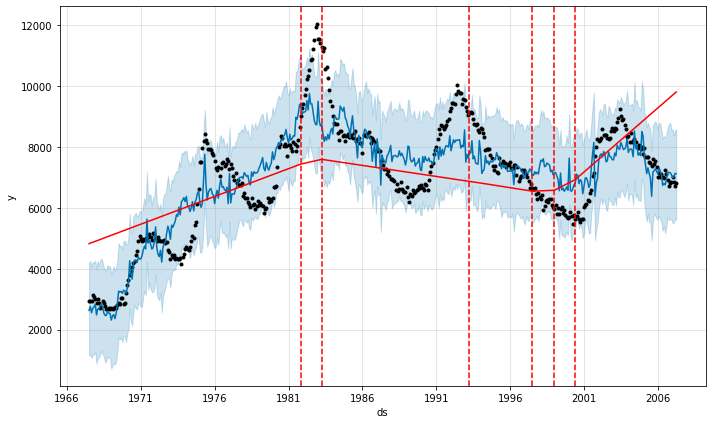

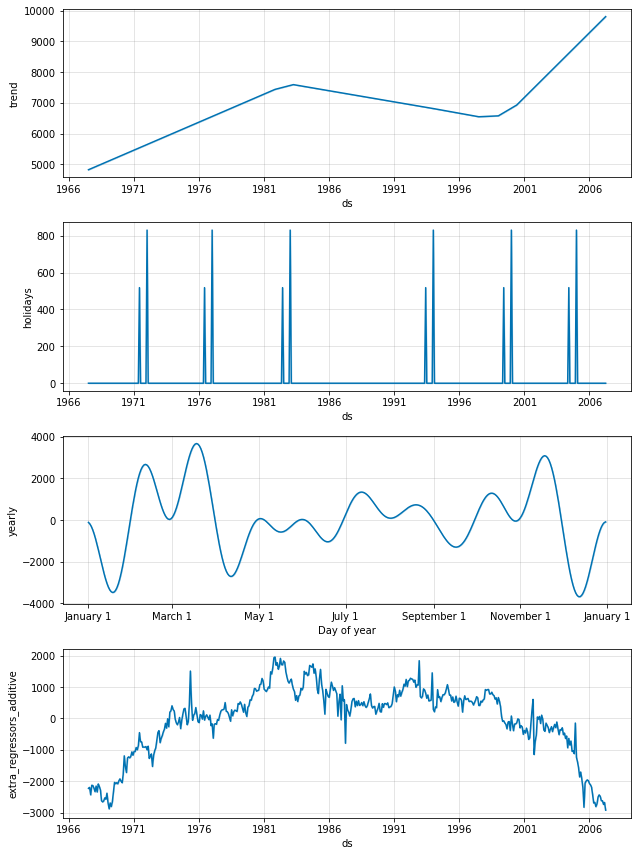

In [87]:
df_pred_multiv, m_multiv, seasonalities = easyprophet.fit_predict(
    df=ts_multiv,           # input df. Must contain 2 colums: "ds" and "y", and optionally all the exogenous variables(x_vars) 
    df_holidays=df_holidays,       # df with columns holiday (string) and ds (date type) (default=[] i.e. No customing holidays)
    x_vars=x_vars,                 # List, Exogenous regressors used to fit y. Note: To predict the future, a dataframe of exogenous regressors is required (default=False)
    x_standardize=x_standardize,   # used only when x_vars not False: Whether to standardize the regressors prior to fitting. Can be 'auto' (standardize if not binary), True, or False. (default="auto")
    plot_predictions=True,         # Boolean, whether to plot the Predictions & Observed values or not
    plot_pred_interactive=True,    # Boolean, whether to plot Predictions & Observed values using an Interactive plots of plotly
    plot_components=True,          # Boolean, whether to plot forecasts components: Trend & seasonalities (weekly/yearly & holidays if added)
    freq_data=freq_data,                             # Frequency of the data, used for making future predictions (pd.date_range format: 'H':hourly, 'D':Daily, 'MS':Month Start, 'M':Month End)
    future_pred_period=False,                        # N° of periods (hours/days/weeks) to predict in the future. False for no future predictions (default=False)
    growth=growth,                                   # linear or logistic trend. If logistic you need to provide cap and floor of your predictions as well as historic data.  (default="linear")
    cap=cap,                                         # Name of the column containing the carrying capacity, i.e. the saturating maximum (must be specified for every row in the df).
    floor=floor,                                     # Name of the column containing the floor (saturating minimum). To use a logistic growth trend with a saturating minimum, a maximum capacity must also be specified.
    yearly_seasonality=yearly_seasonality,           # Whether to include yearly seasonality. Can be 'auto', True, False (default="auto")
    weekly_seasonality=weekly_seasonality,           # Whether to include weekly seasonality. Can be 'auto', True, False (default="auto")
    daily_seasonality=daily_seasonality,             # Whether to include daily seasonality.  Can be 'auto', True, False (default="auto")
    custom_seasonality=custom_seasonality,           # List, containing custom seasonality's [name, freq_period in a year, fourier_order] (e.g ["Quarterly", (365.25/4), 10]
    seasonality_mode=seasonality_mode,               # 'additive' or 'multiplicative' (default="additive")
    seasonality_prior_scale=seasonality_prior_scale, # strength of the seasonality model. larger values => larger seasonal fluctuations (default=10.0)
    holidays_prior_scale=holidays_prior_scale,       # strength of the holiday components model (default=10.0)
    holidays_country=holidays_country,               # name of the country of which load standard holidays (e.g. "US") (default=False)
    interval_width=interval_width,                   # Float, width of the uncertainty intervals provided for the forecast (default=0.80)
    changepoints=changepoints,                       # List of dates at which to include potential changepoints (default=None)
    n_changepoints=n_changepoints,                   # Number of potential changepoints to include. Not used if input `changepoints` is supplied (default=25)
    changepoint_range=changepoint_range,             # Proportion of history in which trend changepoints will be estimated (default=0.80)
    changepoint_prior_scale=changepoint_prior_scale, # Flexibility of automatic changepoint selection & consequently of the trend. Increase it to make the trend more flexible (default=0.05) 
   )

### B.2 Detect Anomalies in the data and export the full table of predictions

In [88]:
df_anom_multiv = easyprophet.detect_anomalies(df_pred_multiv)
print(f"N° of anomalies: {len(df_anom_multiv[df_anom_multiv['anomaly']!=0])} on {len(df_anom_multiv)} rows")

if not sample_data:
    f_out_name = f"{y_var}_predictions_multiv.csv"    # Choose the desired output file name
    df_anom_multiv.to_csv(f"{output_path}{f_out_name}")
    print(f"Exported df containing anomalies & predictions")
    
df_anom_multiv[df_anom_multiv['anomaly']!=0].head()

N° of anomalies: 34 on 478 rows


,ds,trend,yhat_lower,yhat_upper,holidays,pce,pop,psavert,yearly,yhat,fact,anomaly,importance
73,1973-07-31,5934.849291,4476.763901,7538.490090,0.0,4766.945022,-6182.481051,1407.081647,102.567142,6028.962051,4305,-1,0.039899
75,1973-09-30,5965.296223,4715.537240,7811.346112,0.0,4741.220397,-6113.359574,1571.503744,38.068826,6202.729616,4144,-1,0.137919
76,1973-10-31,5980.769254,4629.557378,7752.827088,0.0,4726.398924,-6084.664235,1604.388163,24.826025,6251.718131,4396,-1,0.053130
77,1973-11-30,5995.743155,4820.539944,7884.546146,0.0,4726.739648,-6057.412686,1735.925840,-64.196668,6336.799289,4489,-1,0.073856
78,1973-12-31,6011.216186,4664.615804,7773.538993,0.0,4713.110707,-6030.883033,1604.388163,-91.286366,6206.545657,4644,-1,0.004439


### B.3 Diagnostics: cross validation for a range of historical cutoffs to measure forecast error

#### B.3.1 Use the cross_validation functions. Specify the following parameters:

In [89]:
df_cv_multiv = cross_validation(m_multiv,
                                initial = cv_initial,
                                period  = cv_period,
                                horizon = cv_horizon)
df_cv_multiv.head()

INFO:fbprophet:Making 18 forecasts with cutoffs between 1988-04-04 00:00:00 and 2005-03-31 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1988-04-30,7564.021952,6088.803499,9163.360242,6779,1988-04-04
1,1988-05-31,7589.570817,5980.585930,9128.317742,6546,1988-04-04
2,1988-06-30,7697.294314,6098.396363,9166.322898,6605,1988-04-04
3,1988-07-31,7547.627854,6050.962363,9064.486271,6843,1988-04-04
4,1988-08-31,7610.780773,6112.781737,9115.754689,6604,1988-04-04


#### B.3.2. Compute accuracy of the prediction, as a function of the distance from the cutoff (how far into the future the prediction was), and export the file of performance

In [90]:
df_p_multiv = performance_metrics(df_cv_multiv)
if not sample_data:
    f_out_name = f"{y_var}_performance_multiv.csv"    # Choose the desired output file name
    df_p_multiv.to_csv(f"{output_path}{f_out_name}", index=False)
    print(f"Exported df containing performance of Prophet model")

# Show descriptive statistics of performances
print(df_p_multiv.head())
df_p_multiv.drop(axis=1,columns={"horizon"}).describe()

   horizon           mse         rmse  ...      mape     mdape  coverage
0  88 days  1.244130e+06  1115.405695  ...  0.123698  0.121994  0.819767
1  89 days  1.210931e+06  1100.423174  ...  0.125359  0.123895  0.837209
2  90 days  1.394425e+06  1180.857575  ...  0.133125  0.129757  0.790698
3  91 days  1.384876e+06  1176.807729  ...  0.131619  0.127593  0.790698
4 118 days  1.255546e+06  1120.511428  ...  0.123681  0.121994  0.802326

[5 rows x 7 columns]


,mse,rmse,mae,mape,mdape,coverage
count,1.090000e+02,109.000000,109.000000,109.000000,109.000000,109.000000
mean,2.737743e+06,1625.183655,1368.672935,0.179256,0.178872,0.624013
std,1.007332e+06,312.113423,254.773644,0.032193,0.037282,0.125743
min,1.199812e+06,1095.359329,936.345462,0.121748,0.121994,0.395349
25%,1.969782e+06,1403.489133,1165.920204,0.152918,0.136909,0.534884
50%,2.678390e+06,1636.578678,1380.933340,0.181557,0.194673,0.581395
75%,3.510191e+06,1873.550279,1544.118539,0.201056,0.205527,0.750000
max,4.718692e+06,2172.254939,1819.532416,0.238574,0.240040,0.860465


#### C.3.3 Visualize Cross validation performance metrics

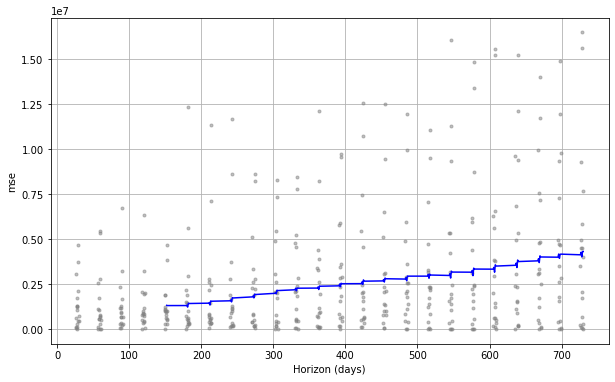

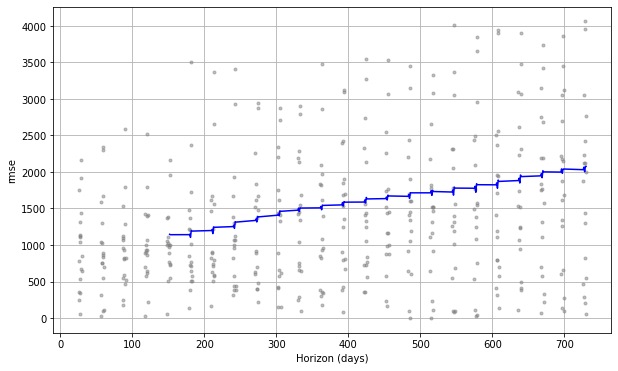

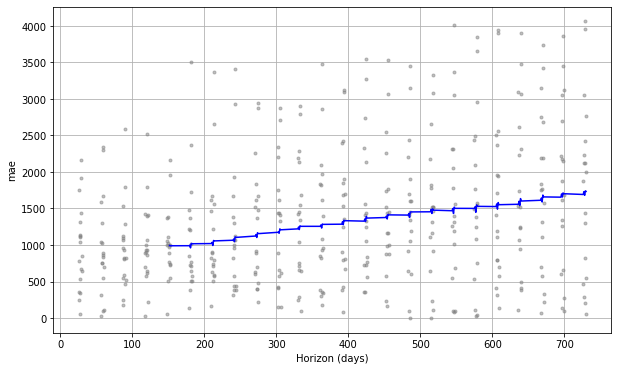

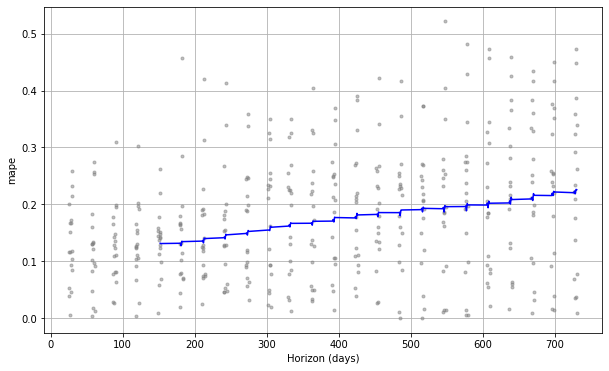

In [91]:
list_metrics = ["mse", "rmse", "mae", "mape"]
for metrics_i in list_metrics:
    fig = plot_cross_validation_metric(df_cv_multiv,
                                       metric=metrics_i,
                                       rolling_window=cv_rolling_window)

### C.4 Models comparison & parameters fine-tuning

#### C.4.1. Fit & compare 2 or more models having some different parameters

1.A Plot of Observed & Predicted values + Changepoints (date points where the time series have abrupt changes in the trajectory)
1.B Plot of Observed & Predicted values - in interactive window


2. Plot of forecasts components: Trend & seasonality (weekly/yearly & holidays if added)


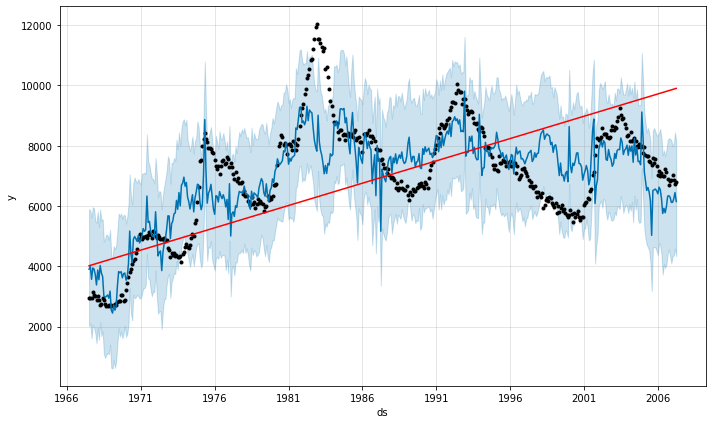

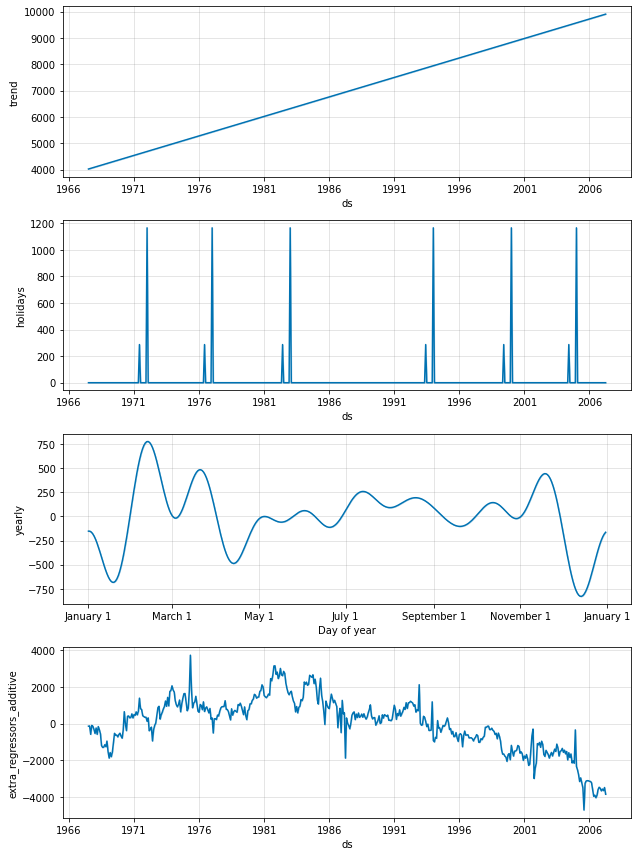

In [92]:
df_pred_multiv, m1_multiv, seasonalities = easyprophet.fit_predict(
    df=ts_multiv,          # input df. Must contain 2 colums: "ds" and "y", and optionally all the exogenous variables(x_vars) 
    df_holidays=df_holidays,       # df with columns holiday (string) and ds (date type) (default=[] i.e. No customing holidays)
    x_vars=x_vars,                 # List, Exogenous regressors used to fit y. Note: To predict the future, a dataframe of exogenous regressors is required (default=False)
    x_standardize=x_standardize,   # used only when x_vars not False: Whether to standardize the regressors prior to fitting. Can be 'auto' (standardize if not binary), True, or False. (default="auto")
    plot_predictions=True,         # Boolean, whether to plot the Predictions & Observed values or not
    plot_pred_interactive=True,    # Boolean, whether to plot Predictions & Observed values using an Interactive plots of plotly
    plot_components=True,          # Boolean, whether to plot forecasts components: Trend & seasonalities (weekly/yearly & holidays if added)
    freq_data=freq_data,                             # Frequency of the data, used for making future predictions (pd.date_range format: 'H':hourly, 'D':Daily, 'MS':Month Start, 'M':Month End)
    future_pred_period=False,                        # N° of periods (hours/days/weeks) to predict in the future. False for no future predictions (default=False)
    growth=growth,                                   # linear or logistic trend. If logistic you need to provide cap and floor of your predictions as well as historic data.  (default="linear")
    cap=cap,                                         # Name of the column containing the carrying capacity, i.e. the saturating maximum (must be specified for every row in the df).
    floor=floor,                                     # Name of the column containing the floor (saturating minimum). To use a logistic growth trend with a saturating minimum, a maximum capacity must also be specified.
    yearly_seasonality=yearly_seasonality,           # Whether to include yearly seasonality. Can be 'auto', True, False (default="auto")
    weekly_seasonality=weekly_seasonality,           # Whether to include weekly seasonality. Can be 'auto', True, False (default="auto")
    daily_seasonality=daily_seasonality,             # Whether to include daily seasonality.  Can be 'auto', True, False (default="auto")
    custom_seasonality=custom_seasonality,           # List, containing custom seasonality's [name, freq_period in a year, fourier_order] (e.g ["Quarterly", (365.25/4), 10]
    seasonality_mode=seasonality_mode,               # 'additive' or 'multiplicative' (default="additive")
    seasonality_prior_scale=seasonality_prior_scale, # strength of the seasonality model. larger values => larger seasonal fluctuations (default=10.0)
    holidays_prior_scale=holidays_prior_scale,       # strength of the holiday components model (default=10.0)
    holidays_country=holidays_country,               # name of the country of which load standard holidays (e.g. "US") (default=False)
    interval_width=interval_width,                   # Float, width of the uncertainty intervals provided for the forecast (default=0.80)
    changepoints=changepoints,                       # List of dates at which to include potential changepoints (default=None)
    n_changepoints=n_changepoints,                   # Number of potential changepoints to include. Not used if input `changepoints` is supplied (default=25)
    changepoint_range=changepoint_range,             # Proportion of history in which trend changepoints will be estimated (default=0.80)
    changepoint_prior_scale=0.01,                    # Flexibility of automatic changepoint selection & consequently of the trend. Increase it to make the trend more flexible (default=0.05) 
    )

1.A Plot of Observed & Predicted values + Changepoints (date points where the time series have abrupt changes in the trajectory)
1.B Plot of Observed & Predicted values - in interactive window


2. Plot of forecasts components: Trend & seasonality (weekly/yearly & holidays if added)


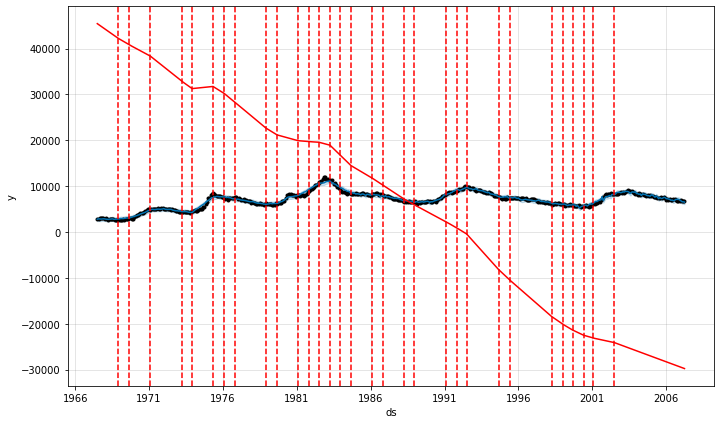

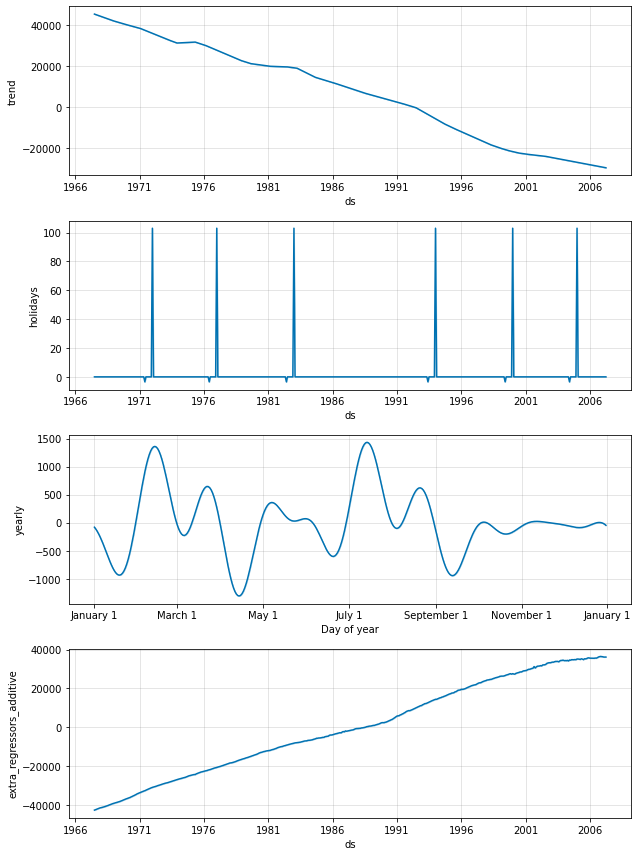

In [93]:
df_pred_multiv, m2_multiv, seasonalities = easyprophet.fit_predict(
    df=ts_multiv,          # input df. Must contain 2 colums: "ds" and "y", and optionally all the exogenous variables(x_vars) 
    df_holidays=df_holidays,       # df with columns holiday (string) and ds (date type) (default=[] i.e. No customing holidays)
    x_vars=x_vars,                 # List, Exogenous regressors used to fit y. Note: To predict the future, a dataframe of exogenous regressors is required (default=False)
    x_standardize=x_standardize,   # used only when x_vars not False: Whether to standardize the regressors prior to fitting. Can be 'auto' (standardize if not binary), True, or False. (default="auto")
    plot_predictions=True,         # Boolean, whether to plot the Predictions & Observed values or not
    plot_pred_interactive=True,    # Boolean, whether to plot Predictions & Observed values using an Interactive plots of plotly
    plot_components=True,          # Boolean, whether to plot forecasts components: Trend & seasonalities (weekly/yearly & holidays if added)
    freq_data=freq_data,                             # Frequency of the data, used for making future predictions (pd.date_range format: 'H':hourly, 'D':Daily, 'MS':Month Start, 'M':Month End)
    future_pred_period=False,                        # N° of periods (hours/days/weeks) to predict in the future. False for no future predictions (default=False)
    growth=growth,                                   # linear or logistic trend. If logistic you need to provide cap and floor of your predictions as well as historic data.  (default="linear")
    cap=cap,                                         # Name of the column containing the carrying capacity, i.e. the saturating maximum (must be specified for every row in the df).
    floor=floor,                                     # Name of the column containing the floor (saturating minimum). To use a logistic growth trend with a saturating minimum, a maximum capacity must also be specified.
    yearly_seasonality=yearly_seasonality,           # Whether to include yearly seasonality. Can be 'auto', True, False (default="auto")
    weekly_seasonality=weekly_seasonality,           # Whether to include weekly seasonality. Can be 'auto', True, False (default="auto")
    daily_seasonality=daily_seasonality,             # Whether to include daily seasonality.  Can be 'auto', True, False (default="auto")
    custom_seasonality=custom_seasonality,           # List, containing custom seasonality's [name, freq_period in a year, fourier_order] (e.g ["Quarterly", (365.25/4), 10]
    seasonality_mode=seasonality_mode,               # 'additive' or 'multiplicative' (default="additive")
    seasonality_prior_scale=seasonality_prior_scale, # strength of the seasonality model. larger values => larger seasonal fluctuations (default=10.0)
    holidays_prior_scale=holidays_prior_scale,       # strength of the holiday components model (default=10.0)
    holidays_country=holidays_country,               # name of the country of which load standard holidays (e.g. "US") (default=False)
    interval_width=interval_width,                   # Float, width of the uncertainty intervals provided for the forecast (default=0.80)
    changepoints=changepoints,                       # List of dates at which to include potential changepoints (default=None)
    n_changepoints=50,                   # Number of potential changepoints to include. Not used if input `changepoints` is supplied (default=25)
    changepoint_range=changepoint_range,             # Proportion of history in which trend changepoints will be estimated (default=0.80)
    changepoint_prior_scale=0.25,                    # Flexibility of automatic changepoint selection & consequently of the trend. Increase it to make the trend more flexible (default=0.05) 
    )

#### C.4.2. Create a grid of parameters to iteratively fit models & compare their diagnostic metrics

In [ ]:
param_grid_multiv = {'model'   : [m_multiv, m1_multiv, m2_multiv],
                     'initial' : [cv_initial],
                     'period'  : [cv_period],
                     'horizon' : [cv_horizon]}

param_grid_multiv = list(easyprophet.create_grid(param_grid_multiv))
print(param_grid_multiv)

cv_table_multiv = easyprophet.cross_validation_compare_models(cross_valid_params=param_grid_multiv, metric='mape')
cv_table_multiv

INFO:fbprophet:Making 18 forecasts with cutoffs between 1988-04-04 00:00:00 and 2005-03-31 00:00:00


[{'horizon': '730 days', 'initial': '7300 days', 'model': <fbprophet.forecaster.Prophet object at 0x7f7adebc7a58>, 'period': '365 days'}, {'horizon': '730 days', 'initial': '7300 days', 'model': <fbprophet.forecaster.Prophet object at 0x7f7ade841e48>, 'period': '365 days'}, {'horizon': '730 days', 'initial': '7300 days', 'model': <fbprophet.forecaster.Prophet object at 0x7f7add73b400>, 'period': '365 days'}]


INFO:fbprophet:Making 18 forecasts with cutoffs between 1988-04-04 00:00:00 and 2005-03-31 00:00:00


INFO:fbprophet:Making 18 forecasts with cutoffs between 1988-04-04 00:00:00 and 2005-03-31 00:00:00
